In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import balanced_accuracy_score
from optuna.samplers import TPESampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE, SMOTENC, SMOTEN
import numpy as np
from sklearn.preprocessing import LabelEncoder
import joblib

/home/tamvlb/miniconda3/envs/tamvlb_work/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BASE_PATH = '/home/tamvlb/VSCode_projects_work/MLOPs_K5_Capstone'
DATA_PATH = '/dataset/raw_data/healthcare-dataset-stroke-data.csv'
SAVE_PROCESSED_DATA_PATH = '/dataset/processed_data/processed_stroke_data.csv'
SAVE_MODEL_PATH = '/model/stroke_pred_model.joblib'

# READ DATA PANDAS DF

In [4]:
data_df = pd.read_csv(BASE_PATH+DATA_PATH)
print(f'Data has shape: {data_df.shape}, columns {data_df.columns.tolist()}')

#Drop id column
data_df = data_df.drop(columns='id', inplace=False)
data_df['bmi'] = data_df['bmi'].fillna(round (data_df['bmi'].median(), 2))
data_df.head(5)

Data has shape: (5110, 12), columns ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [6]:
data_df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.862035,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.699562,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [7]:
# stats of categorical data
round (data_df.describe(exclude = ['float', 'int64']),2)

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


In [8]:
#Define label target, feature columns (object type and number type)
label_col = 'stroke'
object_cols = list(data_df.select_dtypes(include='object'))
print(f'Number of object/string data type columns: {len(object_cols)}. Details: {object_cols}')

num_cols = list(set(data_df.columns.tolist())-set(object_cols)-set([label_col]))
print(f'Number of number data type columns: {len(num_cols)}. Details: {num_cols}')


Number of object/string data type columns: 5. Details: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Number of number data type columns: 5. Details: ['age', 'avg_glucose_level', 'hypertension', 'bmi', 'heart_disease']


# INSIGHT DATA

In [9]:
def plot_hist_cols(df, col_list, label_col, cat_flag):
    n_plot_row = int(np.ceil(len(col_list)/2))
    n_plot_col = 2
    fig, ax = plt.subplots(figsize=(20,n_plot_row*5), nrows=n_plot_row, ncols=n_plot_col)
    col_index = 0
    for row_i in range(n_plot_row):
        for col_i in range(n_plot_col):
            if col_index >= len(col_list):
                break
            cur_col = col_list[col_index]
            if cat_flag == True:
                for unique_val in df[f'{cur_col}'].unique().tolist():
                    ax[row_i][col_i].bar(f'{unique_val}_{label_col}1', df[(df[f'{label_col}']==1) & (df[f'{cur_col}']==unique_val)][f'{cur_col}'].shape[0])
                    ax[row_i][col_i].bar(f'{unique_val}_{label_col}0', df[(df[f'{label_col}']==0) & (df[f'{cur_col}']==unique_val)][f'{cur_col}'].shape[0])
                ax[row_i][col_i].tick_params(axis='x', rotation=15)
            else:
                ax[row_i][col_i].hist(df[f'{cur_col}'])
            ax[row_i][col_i].set_title(f'Histogram plot of {cur_col}')
            col_index+=1

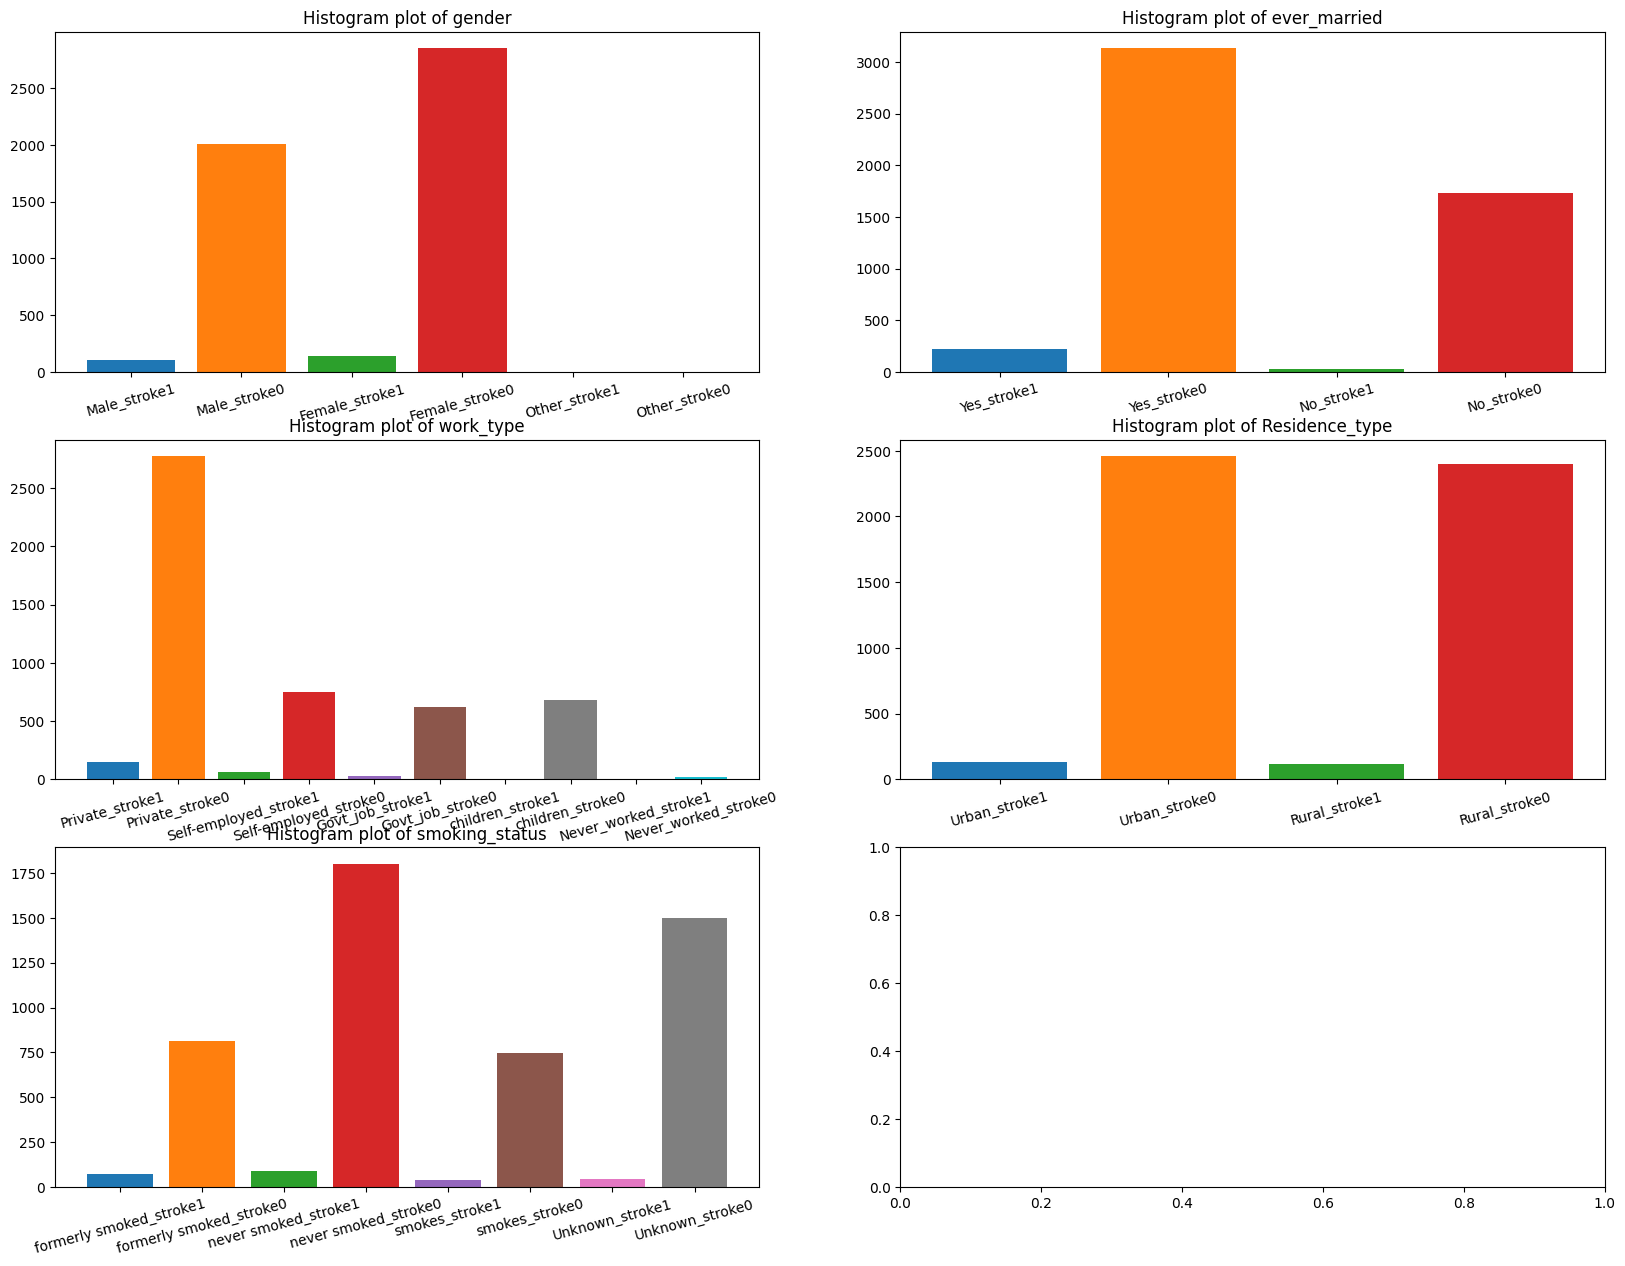

In [10]:
plot_hist_cols(data_df, object_cols, label_col,True)

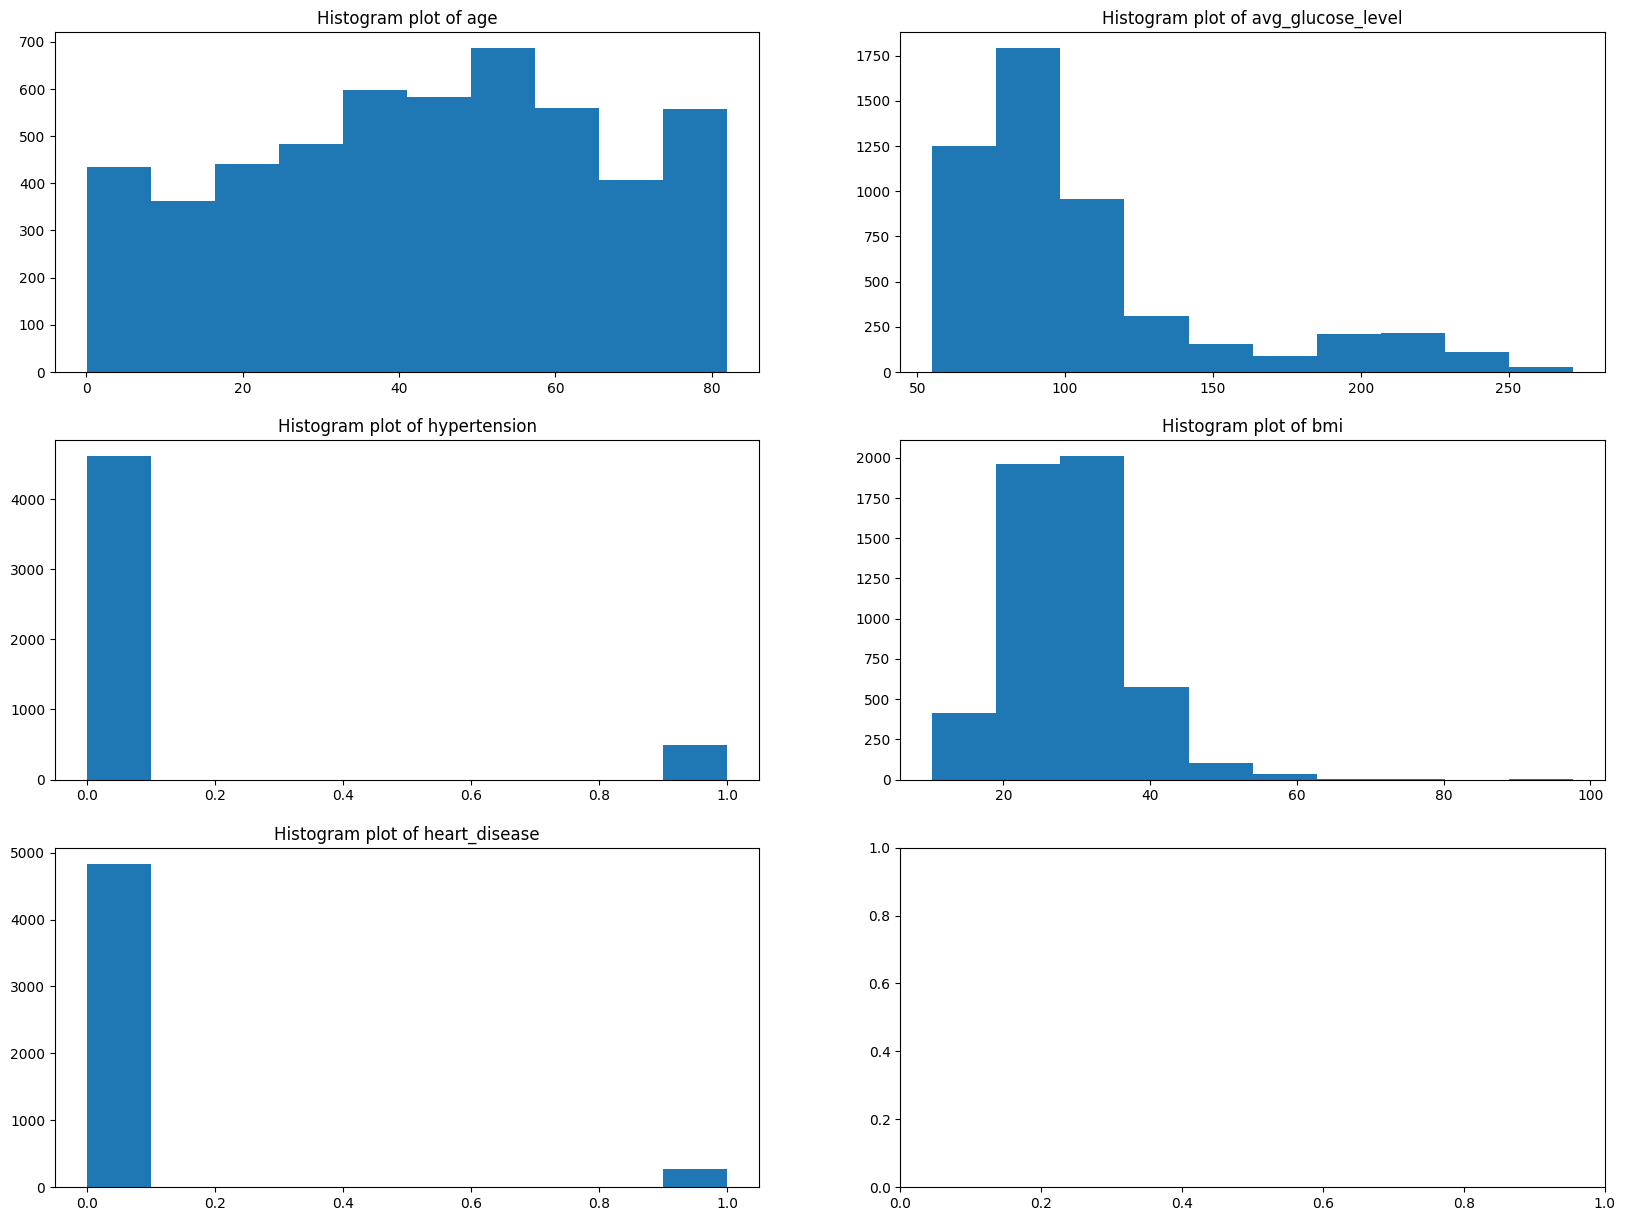

In [11]:
plot_hist_cols(data_df, num_cols, label_col, False)

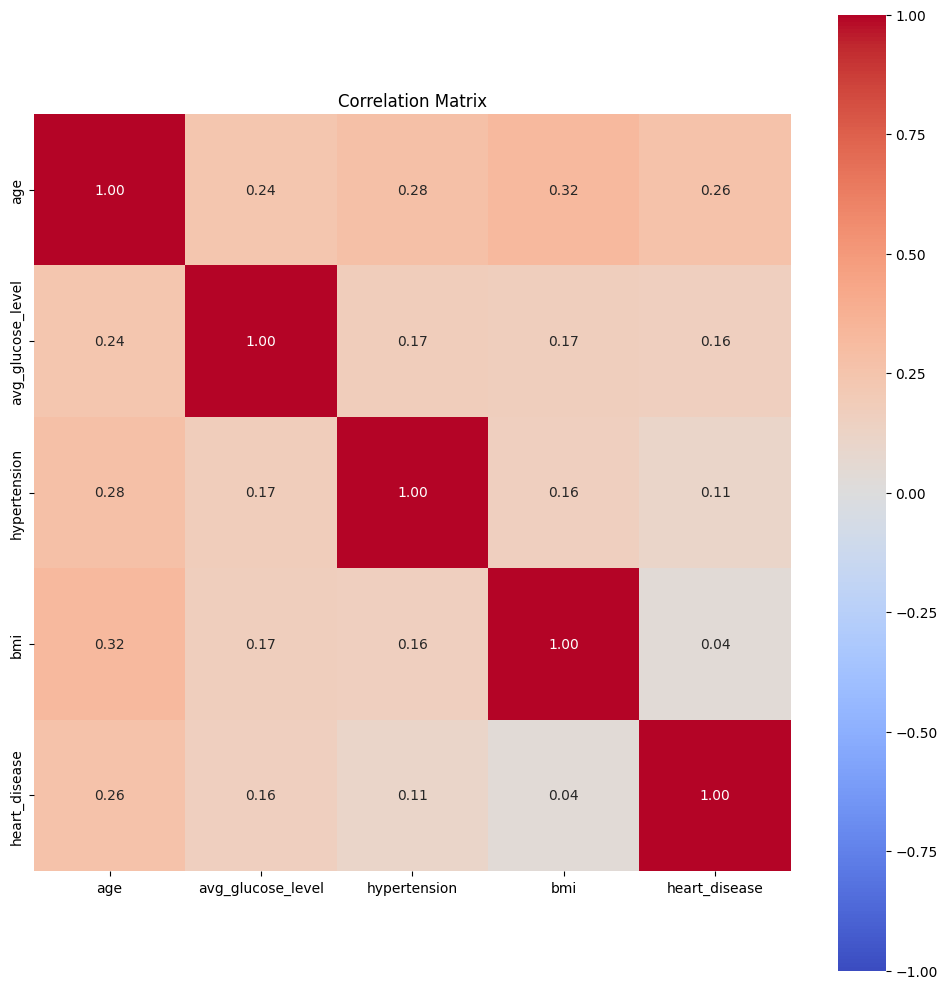

In [12]:
#Plot correlation matrix between number columns
plt.figure(figsize=(10, 10))
sns.heatmap(data_df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, square=True)

plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [19]:
np.percentile(data_df['avg_glucose_level'],95)

216.29450000000003

In [12]:
#Number values to categorical

data_df['bmi_cat'] = pd.cut(data_df['bmi'], bins = [0, np.percentile(data_df['bmi'],25), np.percentile(data_df['bmi'],50),np.percentile(data_df['bmi'],75),10000], labels = ['Underweight', 'Ideal', 'Overweight', 'Obesity'])
data_df['age_cat'] = pd.cut(data_df['age'], bins = [0,13,18, 45,60,200], labels = ['Children', 'Teens', 'Adults','Mid Adults','Elderly'])
data_df['avg_glucose_level_cat'] = pd.cut(data_df['avg_glucose_level'], bins = [0,np.percentile(data_df['avg_glucose_level'],25),np.percentile(data_df['avg_glucose_level'],75),np.percentile(data_df['avg_glucose_level'],95),500], labels = ['Low', 'Normal', 'High', 'Very High'])

In [13]:
data_df['hypertension_cat'] = data_df['hypertension'].map({0: 'No', 1: 'Yes'}).astype('category')
data_df['heart_disease_cat'] = data_df['heart_disease'].map({0: 'No', 1: 'Yes'}).astype('category')

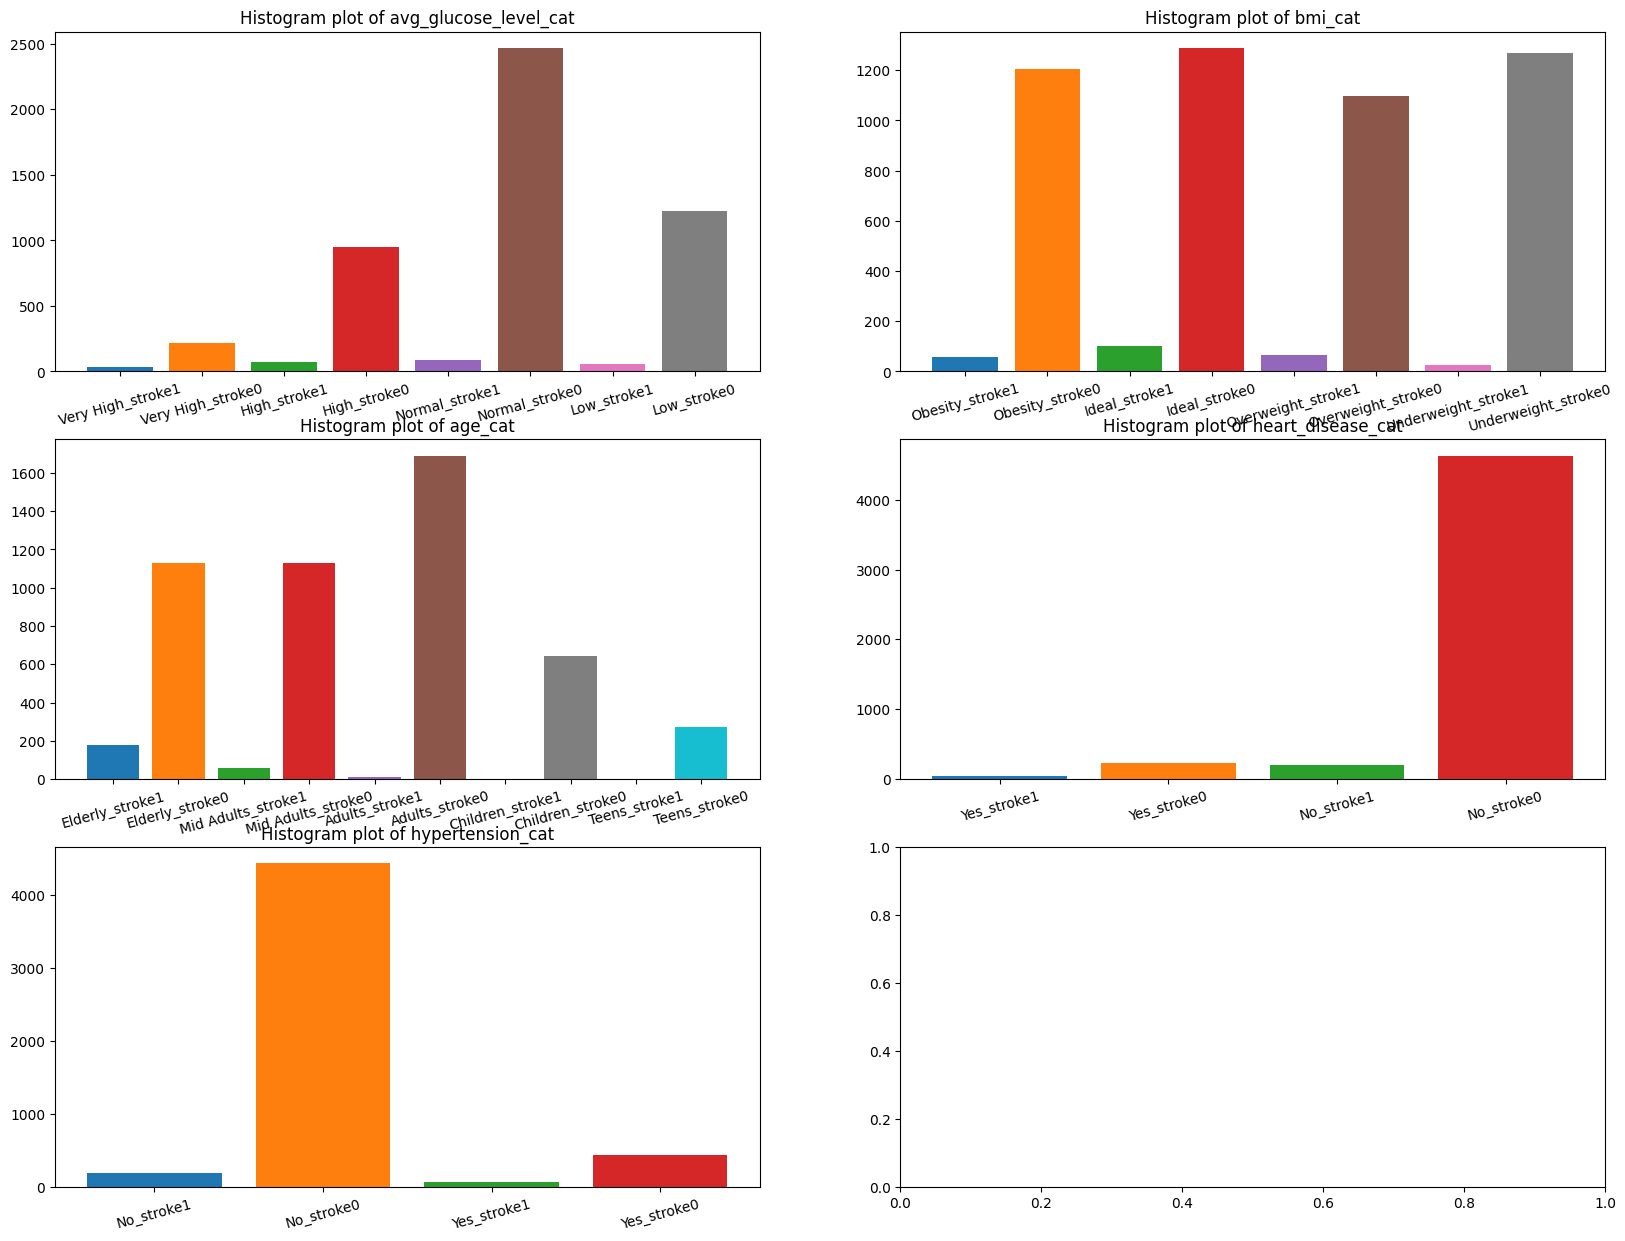

In [14]:
plot_hist_cols(data_df, [col+'_cat' for col in num_cols], label_col, True)

In [15]:
data_df = data_df[object_cols+[col+'_cat' for col in num_cols]+[label_col]]
data_df.head(3)

,gender,ever_married,work_type,Residence_type,smoking_status,avg_glucose_level_cat,bmi_cat,age_cat,heart_disease_cat,hypertension_cat,stroke
0,Male,Yes,Private,Urban,formerly smoked,Very High,Obesity,Elderly,Yes,No,1
1,Female,Yes,Self-employed,Rural,never smoked,High,Ideal,Elderly,No,No,1
2,Male,Yes,Private,Rural,never smoked,Normal,Overweight,Elderly,Yes,No,1


# PREPROCESS DATA

In [16]:
#Standard scaling numbered columns
scaler = StandardScaler()

def normalize_data(df, col_2_norm):
    scaled_values = scaler.fit_transform(df[col_2_norm])
    normalized_cols_name = [f'{col}_norm' for col in col_2_norm]
    for i,norm_col in enumerate(normalized_cols_name):
        df[f'{norm_col}'] = scaled_values[:, i]
    return df, normalized_cols_name

In [17]:
#Normalize number columns
# normalized_data_df, norm_cols = normalize_data(data_df, num_cols)
# normalized_data_df.head(3)

In [18]:
# #Label encoder data

# cat_cols = list(set(data_df.columns)-set([label_col]))
# assert len(cat_cols)==10

# le = LabelEncoder()
# for col in cat_cols:
#     data_df[f'{col}'] = le.fit_transform(data_df[f'{col}'])
# data_df.head(3)

In [19]:
#Save processed data
data_df.to_csv(BASE_PATH+SAVE_PROCESSED_DATA_PATH, index=False)

In [20]:
data_df

,gender,ever_married,work_type,Residence_type,smoking_status,avg_glucose_level_cat,bmi_cat,age_cat,heart_disease_cat,hypertension_cat,stroke
0,Male,Yes,Private,Urban,formerly smoked,Very High,Obesity,Elderly,Yes,No,1
1,Female,Yes,Self-employed,Rural,never smoked,High,Ideal,Elderly,No,No,1
2,Male,Yes,Private,Rural,never smoked,Normal,Overweight,Elderly,Yes,No,1
3,Female,Yes,Private,Urban,smokes,High,Obesity,Mid Adults,No,No,1
4,Female,Yes,Self-employed,Rural,never smoked,High,Ideal,Elderly,No,Yes,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,Yes,Private,Urban,never smoked,Normal,Ideal,Elderly,No,Yes,0
5106,Female,Yes,Self-employed,Urban,never smoked,High,Obesity,Elderly,No,No,0
5107,Female,Yes,Self-employed,Rural,never smoked,Normal,Overweight,Adults,No,No,0
5108,Male,Yes,Private,Rural,formerly smoked,High,Ideal,Mid Adults,No,No,0


In [19]:
#Define X feature and y label
data_df = data_df.sample(frac=1).reset_index(drop=True)

cat_cols = [col for col in data_df.columns if col != label_col]
X_data = data_df[cat_cols]
y_data = data_df[label_col]
print(X_data.shape, y_data.shape)

(5110, 10) (5110,)


In [20]:
X_data.head(3)

,gender,ever_married,work_type,Residence_type,smoking_status,avg_glucose_level_cat,bmi_cat,age_cat,heart_disease_cat,hypertension_cat
0,Female,No,children,Urban,Unknown,Normal,Underweight,Children,No,No
1,Male,No,children,Rural,never smoked,Normal,Underweight,Children,No,No
2,Male,Yes,Private,Rural,smokes,Normal,Ideal,Elderly,Yes,No


# TRAIN VAL TEST DATA SPLIT

In [21]:
#Split train val test : train 0.75, val 0.15, test 0.1
SEED = 10

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.25, random_state=SEED) 
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.1/0.25, random_state=SEED)

assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == X_data.shape[0]

print(f'Train data shape: {X_train.shape}, validate data shape: {X_val.shape}, test data shape: {X_test.shape}')
print(f'Label count in train data: {y_train.value_counts(normalize=True)}, validate data: {y_val.value_counts(normalize=True)}, test data: {y_test.value_counts(normalize=True)}')

Train data shape: (3832, 10), validate data shape: (766, 10), test data shape: (512, 10)
Label count in train data: stroke
0    0.953549
1    0.046451
Name: proportion, dtype: float64, validate data: stroke
0    0.951697
1    0.048303
Name: proportion, dtype: float64, test data: stroke
0    0.933594
1    0.066406
Name: proportion, dtype: float64


In [28]:
smote = SMOTEN()
X_resample, y_resample = smote.fit_resample(X_train, y_train)
print(f'Training data after resample: {X_resample.shape}')


Training data after resample: (7308, 10)


In [32]:
#Create catboost pool

train_data = Pool(X_resample, y_resample, cat_features=cat_cols)
val_data = Pool(X_val, y_val, cat_features=cat_cols)
test_data = Pool(X_test, y_test, cat_features=cat_cols)

# MODEL TRAINING

In [33]:
#Optuna func

def objective_func(trial):
    model_params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True),
        "iterations": trial.suggest_int("iterations", 500, 1500),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 10, log=True),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "od_pval": trial.suggest_float("od_pval", 0.001, 0.1),
        "od_wait": trial.suggest_int("od_wait", 10, 20),
        "od_type": "Iter", 
        "eval_metric": "BalancedAccuracy", 
        "loss_function": 'CrossEntropy', 
        "bootstrap_type": "Bernoulli" 
    }

    model = CatBoostClassifier(**model_params)
    model.fit(train_data, eval_set=val_data, early_stopping_rounds=50, verbose=False)
    preds = model.predict(X_val)
    return balanced_accuracy_score(y_val, preds)

In [34]:
#Optuna trial
study = optuna.create_study(direction='maximize')#, sampler=TPESampler())
study.optimize(objective_func, n_trials=10)

print(f"Best trial: {study.best_trial.params}")
print(f"Best value: {study.best_value}")

[I 2025-05-05 22:46:44,863] A new study created in memory with name: no-name-8194556f-4ea3-4af0-ab5e-83ca62ba60ff
[I 2025-05-05 22:46:45,345] Trial 0 finished with value: 0.8150187224261298 and parameters: {'learning_rate': 0.007827002762409708, 'iterations': 522, 'max_depth': 4, 'l2_leaf_reg': 3, 'subsample': 0.901925424112244, 'od_pval': 0.05767181227321692, 'od_wait': 11}. Best is trial 0 with value: 0.8150187224261298.
[I 2025-05-05 22:46:45,813] Trial 1 finished with value: 0.808845882919957 and parameters: {'learning_rate': 0.000362101368072299, 'iterations': 1388, 'max_depth': 5, 'l2_leaf_reg': 9, 'subsample': 0.789469844798777, 'od_pval': 0.06549478588480173, 'od_wait': 12}. Best is trial 0 with value: 0.8150187224261298.
[I 2025-05-05 22:46:48,905] Trial 2 finished with value: 0.6469432395358321 and parameters: {'learning_rate': 0.000963669934919681, 'iterations': 953, 'max_depth': 12, 'l2_leaf_reg': 1, 'subsample': 0.8405003255918229, 'od_pval': 0.03044102779524049, 'od_wait'

Best trial: {'learning_rate': 0.007827002762409708, 'iterations': 522, 'max_depth': 4, 'l2_leaf_reg': 3, 'subsample': 0.901925424112244, 'od_pval': 0.05767181227321692, 'od_wait': 11}
Best value: 0.8150187224261298


In [35]:
study.best_trial.params

{'learning_rate': 0.007827002762409708,
 'iterations': 522,
 'max_depth': 4,
 'l2_leaf_reg': 3,
 'subsample': 0.901925424112244,
 'od_pval': 0.05767181227321692,
 'od_wait': 11}

In [36]:
model_clf = CatBoostClassifier(**study.best_trial.params, od_type='Iter', eval_metric='BalancedAccuracy', loss_function='CrossEntropy', bootstrap_type = 'Bernoulli', verbose = 500)
model_clf.fit(train_data, eval_set=val_data, early_stopping_rounds=50)

0:	learn: 0.7738095	test: 0.8047307	best: 0.8047307 (0)	total: 7.94ms	remaining: 4.14s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8150187224
bestIteration = 28

Shrink model to first 29 iterations.


# MODEL INFERECE

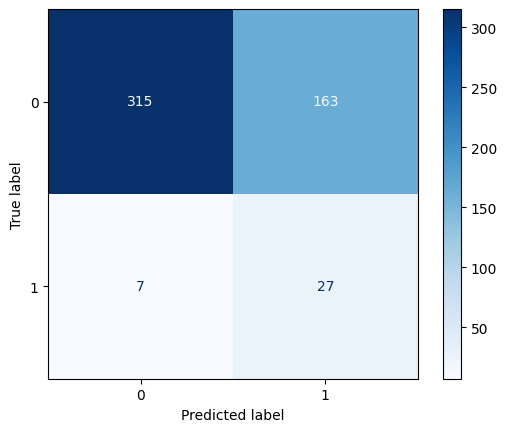

In [37]:
test_pred = model_clf.predict(X_test)

#Plot confusion matrix
cm = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

In [38]:
#Saving model
joblib.dump(model_clf, BASE_PATH+SAVE_MODEL_PATH)

['/home/tamvlb/VSCode_projects_work/MLOPs_K5_Capstone/model/stroke_pred_model.joblib']